## Pembuatan Model Deep Learning LSTM-GRU, Prediksi Harga Komoditas Pangan Pasar Kramat Kota Cirebon.

Authored by : Hafiz Caniago.

## Setup Variabel

In [1]:
# Dapat Dirubah
## List Komoditas
comodity_list = ['bawang_merah', 'cabai_merah_besar', 'cabai_merah_keriting', 'cabai_rawit_hijau', 'cabai_rawit_merah'];
# Pilih Komoditas :
# 0 = bawang merah, 1 = cabai merah besar, 2 = cabai merah keriting,
# 3 = cabai rawit hijau, 4 = cabai rawit merah
comodity_selected = 0;

## Hyperparameter
set_max_epochs = 100; # 100, 150
set_neurons = 16; # 16, 32, 64
set_batch_size = 32; # 32

# Tidak Dirubah
set_test_size = 0.2; # Panjang Data Test
set_window_size = 30; # Panjang Data Pola Time Series

## Kode Tambahan
y_axis_title_comodity = ['Harga Bawang Merah', 'Harga Cabai Merah Besar',
                         'Harga Cabai Merah Keriting', 'Harga Cabai Rawit Hijau',
                         'Harga Cabai Rawit Merah']
chart_title = 'Historis Data ' + y_axis_title_comodity[comodity_selected]

## Import Library

In [2]:
# numpy & matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Sklearn Lib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error

# Tensorflow
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import LSTM, GRU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# JobLib
import joblib

In [3]:
!pip freeze > requirements.txt

## Data Preparation


In [4]:
# Baca CSV File
df = pd.read_csv('/content/dataset.csv')

In [5]:
# Preview Data
df

,date,cabai_merah_besar,cabai_merah_keriting,cabai_rawit_hijau,cabai_rawit_merah,bawang_merah
0,2021-05-03,39000,37000,32000,60000,29000
1,2021-05-04,39000,39000,29000,70000,29000
2,2021-05-05,37000,37000,28000,70000,29000
3,2021-05-06,39000,39000,28000,70000,29000
4,2021-05-07,39000,40000,30000,70000,31000
...,...,...,...,...,...,...
1092,2024-04-29,60000,60000,32000,49000,60000
1093,2024-04-30,60000,60000,30000,49000,60000
1094,2024-05-01,59500,60000,33000,49000,57500
1095,2024-05-02,59000,60000,36000,49000,55000


In [6]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  1097 non-null   object
 1   cabai_merah_besar     1097 non-null   int64 
 2   cabai_merah_keriting  1097 non-null   int64 
 3   cabai_rawit_hijau     1097 non-null   int64 
 4   cabai_rawit_merah     1097 non-null   int64 
 5   bawang_merah          1097 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 51.6+ KB


In [7]:
df.describe()

,cabai_merah_besar,cabai_merah_keriting,cabai_rawit_hijau,cabai_rawit_merah,bawang_merah
count,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000
mean,42176.162261,46441.886964,39445.077484,58527.803099,33160.893345
std,19287.677455,18727.108870,13950.812254,20627.575250,8924.155856
min,16000.000000,17000.000000,17000.000000,24500.000000,19000.000000
25%,29000.000000,34500.000000,31000.000000,43682.000000,28500.000000
50%,35500.000000,41000.000000,36000.000000,54000.000000,31000.000000
75%,50000.000000,60000.000000,46333.000000,70000.000000,35500.000000
max,110000.000000,105000.000000,100000.000000,120000.000000,70000.000000


In [8]:
# Mentransformasikan Data ke Format Datetime
df.date = pd.to_datetime(df.date, format = '%Y-%m-%d')
df.sort_values(by='date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Mentransformasikan Data ke Format Integer (Harga Pangan tidak perlu koma)
columns_to_convert = df.columns[1:]  # Exclude the 'date' column
df[columns_to_convert] = df[columns_to_convert].astype('float64')

In [9]:
# Dataset info after transformation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1097 non-null   datetime64[ns]
 1   cabai_merah_besar     1097 non-null   float64       
 2   cabai_merah_keriting  1097 non-null   float64       
 3   cabai_rawit_hijau     1097 non-null   float64       
 4   cabai_rawit_merah     1097 non-null   float64       
 5   bawang_merah          1097 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 51.6 KB


In [10]:
# Preview Data after transformation
df

,date,cabai_merah_besar,cabai_merah_keriting,cabai_rawit_hijau,cabai_rawit_merah,bawang_merah
0,2021-05-03,39000.0,37000.0,32000.0,60000.0,29000.0
1,2021-05-04,39000.0,39000.0,29000.0,70000.0,29000.0
2,2021-05-05,37000.0,37000.0,28000.0,70000.0,29000.0
3,2021-05-06,39000.0,39000.0,28000.0,70000.0,29000.0
4,2021-05-07,39000.0,40000.0,30000.0,70000.0,31000.0
...,...,...,...,...,...,...
1092,2024-04-29,60000.0,60000.0,32000.0,49000.0,60000.0
1093,2024-04-30,60000.0,60000.0,30000.0,49000.0,60000.0
1094,2024-05-01,59500.0,60000.0,33000.0,49000.0,57500.0
1095,2024-05-02,59000.0,60000.0,36000.0,49000.0,55000.0


In [11]:
# Panjang Data
print("Panjang Data : ", len(df))

Panjang Data :  1097


In [12]:
# Check Duplicates data
df.duplicated(subset=['date'])

,0
0,False
1,False
2,False
3,False
4,False
...,...
1092,False
1093,False
1094,False
1095,False


In [13]:
# Check Null Data
df.isnull().sum().sum()

np.int64(0)

### Preview Chart Comodity

In [14]:
# Ploting Chart Data Historis
fig = px.line(y=df[comodity_list[comodity_selected]], x=df.date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Waktu Historis",
                  yaxis_title=y_axis_title_comodity[comodity_selected],
                  title={'text': chart_title, 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

### Normalisasi, Split Data Training & Testing, Pembentukan Pola Time Series

In [15]:
# Data Scaling
scaler = MinMaxScaler()
scaler.fit(df[comodity_list[comodity_selected]].values.reshape(-1,1))

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [16]:
# Set Panjang Data Test
test_size = int(len(df) * set_test_size)
test_size

219

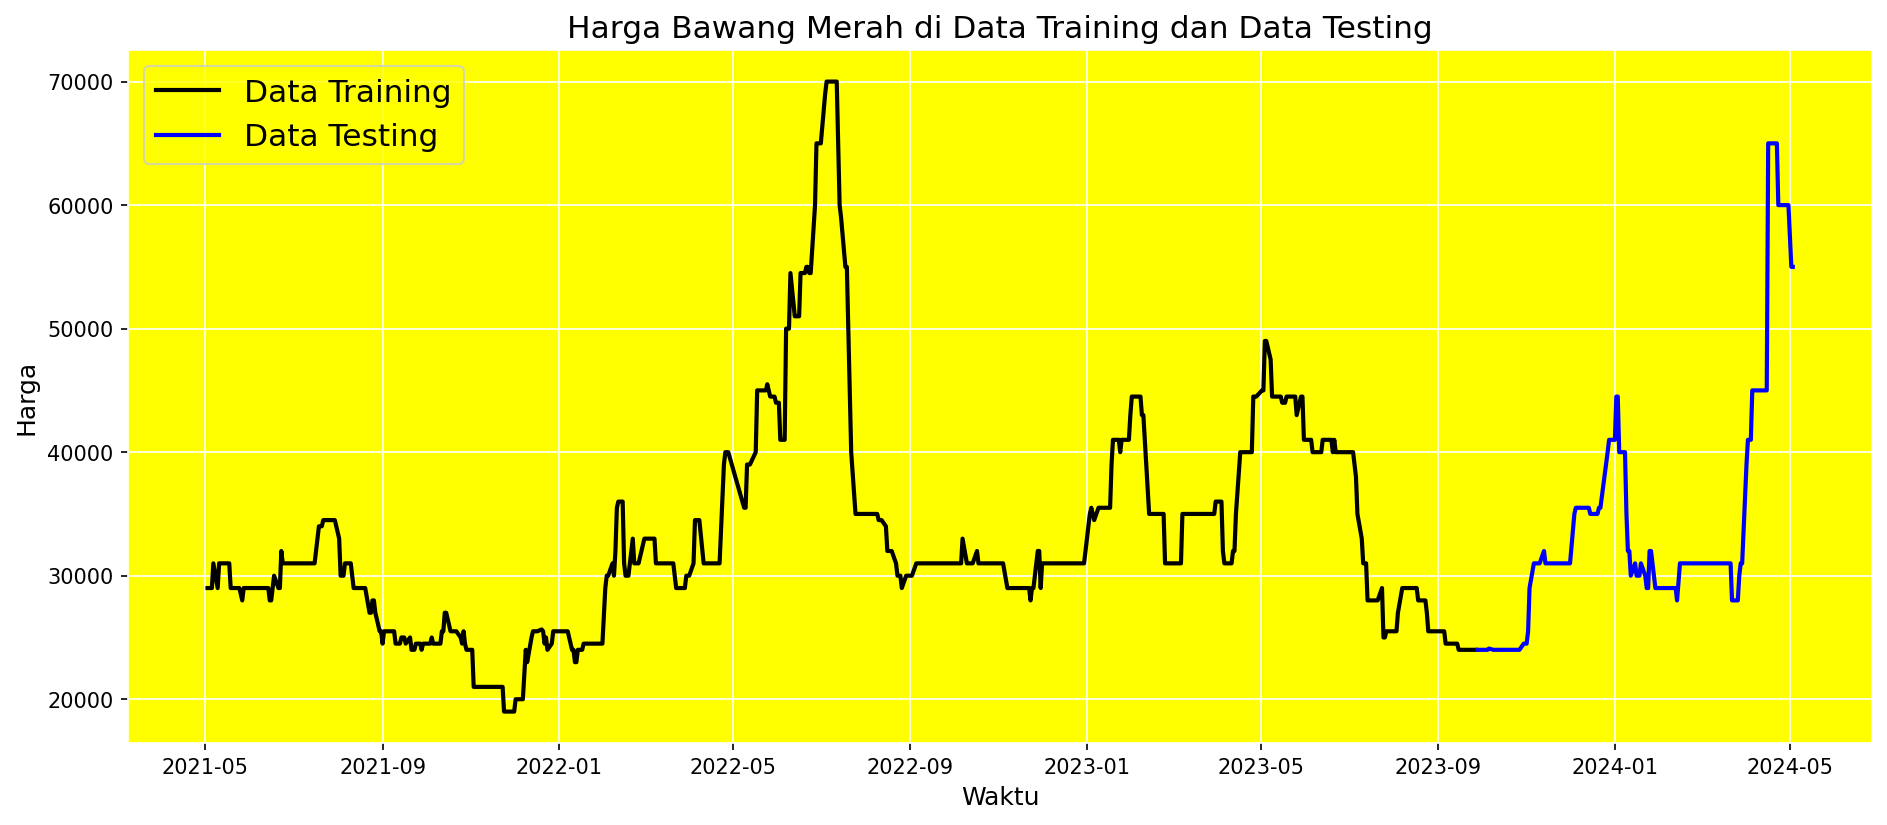

In [17]:
# Ploting Data Training dan Test
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.date[:-test_size], df[comodity_list[comodity_selected]][:-test_size], color='black', lw=2)
plt.plot(df.date[-test_size:], df[comodity_list[comodity_selected]][-test_size:], color='blue', lw=2)
plt.title(y_axis_title_comodity[comodity_selected] + ' di Data Training dan Data Testing', fontsize=15)
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.legend(['Data Training', 'Data Testing'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [18]:
# Panjang data Loopback x hari
window_size = set_window_size

# Persiapkan data Training 80% dari data, dan normalisasikan
train_data = df[comodity_list[comodity_selected]][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

# Membulatkan hingga 6 angka di belakang koma
train_data = np.round(train_data, 6)

# Siapkan Variable untuk menampung data Train, disesuaikan dengan data loopback yaitu 30
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])

In [19]:
print("Panjang Data Train : ", len(train_data))
print("Panjang Data Train X - loopback : ", len(X_train))
print("Panjang Data Train y - loopback : ", len(y_train))

Panjang Data Train :  878
Panjang Data Train X - loopback :  848
Panjang Data Train y - loopback :  848


In [20]:
# Persiapkan data test
test_data = df[comodity_list[comodity_selected]][-test_size-30:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

# Membulatkan hingga 6 angka di belakang koma
test_data = np.round(test_data, 6)

# Siapkan Variable untuk menampung data Test, disesuaikan dengan data loopback yaitu 30
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-30:i, 0])
    y_test.append(test_data[i, 0])

In [21]:
print("Panjang Data Test : ", len(test_data))
print("Panjang Data Test X - loopback : ", len(X_test))
print("Panjang Data Test y - loopback : ", len(y_test))

Panjang Data Test :  249
Panjang Data Test X - loopback :  219
Panjang Data Test y - loopback :  219


In [22]:
# Now X_train and X_test are nested lists (two-dimensional lists) and y_train is a one-dimensional list.
# We need to convert them to numpy arrays with a higher dimension,
# which is the data format accepted by TensorFlow when training the neural network:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (848, 30, 1)
y_train Shape:  (848, 1)
X_test Shape:   (219, 30, 1)
y_test Shape:   (219, 1)


## Training Model

In [23]:
# Create LSTM + GRU Model
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = set_neurons, return_sequences=True)(input1)
    x = GRU(units = set_neurons)(x)  # Setting return_sequences=False to get 2D output
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer=Adam())
    model.summary()

    return model

In [24]:
# Training Model
model = define_model()
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# Fit the model with the checkpoint callback
history = model.fit(X_train, y_train, epochs=set_max_epochs, batch_size=set_batch_size, validation_split=0.1, verbose=1, callbacks=[checkpoint])
# Load the best model saved during training
model = load_model('best_model.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0568
Epoch 1: val_loss improved from inf to 0.02238, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0489 - val_loss: 0.0224
Epoch 2/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103
Epoch 2: val_loss improved from 0.02238 to 0.00559, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0101 - val_loss: 0.0056
Epoch 3/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056
Epoch 3: val_loss improved from 0.00559 to 0.00215, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 4/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034
Epoch 4: val_loss improved from 0.00215 to 0.00202, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 5/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034
Epoch 5: val_loss did not improve from 0.00202
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 6/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 6: val_loss did not improve from 0.00202
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 7/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031
Epoch 7: val_loss improved from 0.00202 to 0.00185, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 8/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 8: val_loss improved from 0.00185 to 0.00119, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 9/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 9: val_loss did not improve from 0.00119
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 10/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 10: val_loss did not improve from 0.00119
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 11/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 11: val_loss improved from 0.00119 to 0.00077, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 7.7329e-04
Epoch 12/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 12: val_loss did not improve from 0.00077
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 13/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 13: val_loss did not improve from 0.00077
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 8.2673e-04
Epoch 14/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 14: val_loss improved from 0.00077 to 0.00068, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 6.8218e-04
Epoch 15/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 15: val_loss did not improve from 0.00068
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 16/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 16: val_loss did not improve from 0.00068
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 7.9303e-04
Epoch 17/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 17: val_loss did not improve from 0.00068
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 7.3636e-04
Epoch 18/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 18: val_loss did not improve from 0.00068
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 8.4607e-04
Epoch 19/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6758e-04
Epoch 19: val_loss did not improve from 0.00068
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/s

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 5.3180e-04
Epoch 21/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3849e-04
Epoch 21: val_loss did not improve from 0.00053
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.7643e-04 - val_loss: 6.1403e-04
Epoch 22/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8933e-04
Epoch 22: val_loss did not improve from 0.00053
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.0247e-04 - val_loss: 7.1654e-04
Epoch 23/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4794e-04
Epoch 23: val_loss did not improve from 0.00053
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.5732e-04 - val_loss: 6.1533e-04
Epoch 24/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7291e-04
Epoch 24: val_loss improved from 0.00053 to 0.00050, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.0776e-04 - val_loss: 4.9998e-04
Epoch 25/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 25: val_loss did not improve from 0.00050
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 6.7125e-04
Epoch 26/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2818e-04
Epoch 26: val_loss did not improve from 0.00050
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.2601e-04 - val_loss: 6.6447e-04
Epoch 27/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7595e-04
Epoch 27: val_loss did not improve from 0.00050
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.7830e-04 - val_loss: 5.8044e-04
Epoch 28/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2936e-04
Epoch 28: val_loss did not improve from 0.00050
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0161e-04 - val_loss: 6.6036e-04
Epoch 29/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1446e-04
Epoch 29: val_loss did not improve from 0.00050
24/

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.5032e-04 - val_loss: 4.2450e-04
Epoch 37/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3106e-04
Epoch 37: val_loss improved from 0.00042 to 0.00040, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5103e-04 - val_loss: 4.0367e-04
Epoch 38/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0801e-04
Epoch 38: val_loss improved from 0.00040 to 0.00040, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8101e-04 - val_loss: 3.9700e-04
Epoch 39/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.5607e-04
Epoch 39: val_loss did not improve from 0.00040
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9210e-04 - val_loss: 5.1218e-04
Epoch 40/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5953e-04
Epoch 40: val_loss improved from 0.00040 to 0.00037, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6396e-04 - val_loss: 3.6618e-04
Epoch 41/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9244e-04
Epoch 41: val_loss improved from 0.00037 to 0.00037, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1021e-04 - val_loss: 3.6602e-04
Epoch 42/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4306e-04
Epoch 42: val_loss improved from 0.00037 to 0.00036, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6265e-04 - val_loss: 3.5850e-04
Epoch 43/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6911e-04
Epoch 43: val_loss did not improve from 0.00036
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9200e-04 - val_loss: 4.1330e-04
Epoch 44/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9610e-04
Epoch 44: val_loss did not improve from 0.00036
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9917e-04 - val_loss: 6.2356e-04
Epoch 45/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8967e-04
Epoch 45: val_loss did not improve from 0.00036
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8907e-04 - val_loss: 5.6090e-04
Epoch 46/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8052e-04
Epoch 46: val_loss did not improve from 0.00036
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9653e-04 - val_loss: 4.9203e-04
Epoch 47/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5350e-04
Epoch 47: val_loss did not improve from 0.0003

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4900e-04 - val_loss: 3.3085e-04
Epoch 50/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2394e-04
Epoch 50: val_loss did not improve from 0.00033
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5486e-04 - val_loss: 3.7943e-04
Epoch 51/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1983e-04
Epoch 51: val_loss improved from 0.00033 to 0.00031, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9665e-04 - val_loss: 3.1373e-04
Epoch 52/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8734e-04
Epoch 52: val_loss did not improve from 0.00031
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8339e-04 - val_loss: 3.8237e-04
Epoch 53/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7832e-04
Epoch 53: val_loss improved from 0.00031 to 0.00031, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6093e-04 - val_loss: 3.0596e-04
Epoch 54/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8978e-04
Epoch 54: val_loss improved from 0.00031 to 0.00026, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3646e-04 - val_loss: 2.6329e-04
Epoch 55/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8909e-04
Epoch 55: val_loss did not improve from 0.00026
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8715e-04 - val_loss: 2.8548e-04
Epoch 56/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5835e-04
Epoch 56: val_loss did not improve from 0.00026
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7370e-04 - val_loss: 2.7231e-04
Epoch 57/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9394e-04
Epoch 57: val_loss did not improve from 0.00026
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9454e-04 - val_loss: 2.7424e-04
Epoch 58/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0596e-04
Epoch 58: val_loss did not improve from 0.00026
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0487e-04 - val_loss: 2.9509e-04
Epoch 59/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0392e-04
Epoch 59: val_loss did not improve from 0.000

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3127e-04 - val_loss: 2.4677e-04
Epoch 71/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9472e-04
Epoch 71: val_loss did not improve from 0.00025
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0734e-04 - val_loss: 3.6838e-04
Epoch 72/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7583e-04
Epoch 72: val_loss did not improve from 0.00025
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8796e-04 - val_loss: 2.6570e-04
Epoch 73/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2154e-04
Epoch 73: val_loss did not improve from 0.00025
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1646e-04 - val_loss: 2.6319e-04
Epoch 74/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4360e-04
Epoch 74: val_loss improved from 0.00025 to 0.00023, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4057e-04 - val_loss: 2.2564e-04
Epoch 75/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1438e-04
Epoch 75: val_loss did not improve from 0.00023
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1302e-04 - val_loss: 2.3399e-04
Epoch 76/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3454e-04
Epoch 76: val_loss did not improve from 0.00023
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4985e-04 - val_loss: 2.2876e-04
Epoch 77/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6647e-04
Epoch 77: val_loss did not improve from 0.00023
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5711e-04 - val_loss: 2.2658e-04
Epoch 78/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0519e-04
Epoch 78: val_loss did not improve from 0.00023
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2266e-04 - val_loss: 2.4749e-04
Epoch 79/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3355e-04
Epoch 79: val_loss did not improve from 0.00

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1655e-04 - val_loss: 2.1974e-04
Epoch 82/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2374e-04
Epoch 82: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1716e-04 - val_loss: 2.5707e-04
Epoch 83/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8698e-04
Epoch 83: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0802e-04 - val_loss: 4.9634e-04
Epoch 84/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6235e-04
Epoch 84: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7937e-04 - val_loss: 2.6063e-04
Epoch 85/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5440e-04
Epoch 85: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3618e-04 - val_loss: 2.3258e-04
Epoch 86/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8643e-04
Epoch 86: val_loss did not improve from 0.000

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1077e-04 - val_loss: 2.1507e-04
Epoch 90/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1439e-04
Epoch 90: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3419e-04 - val_loss: 2.2043e-04
Epoch 91/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0623e-04
Epoch 91: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9830e-04 - val_loss: 2.4301e-04
Epoch 92/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0716e-04
Epoch 92: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2168e-04 - val_loss: 3.2840e-04
Epoch 93/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6559e-04
Epoch 93: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6578e-04 - val_loss: 2.2203e-04
Epoch 94/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2746e-04
Epoch 94: val_loss did not improve from 0.000

## Evaluasi Model

In [25]:
# Model Evaluation (Data Normalisasi)
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
# Membulatkan angka koma normalisasi maksimal 6
y_pred = np.round(y_pred, 6)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8195e-04  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [26]:
# Calculate Evaluation Value of Model
MAPE = mean_absolute_percentage_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
Accuracy = 1 - MAPE

print("Test Loss (MSE):", result) # MSE
print("Test RMSE:", RMSE)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss (MSE): 0.0011948698665946722
Test RMSE: 0.034566878222976216
Test MAPE: 0.04133664902587545
Test Accuracy: 0.9586633509741246


In [27]:
# Kalkulasi Evaluasi Model (Data Denormalisasi / Asli)
y_test_true_dn = np.round(scaler.inverse_transform(y_test)) # Dibulatkan
y_test_pred_dn = np.round(scaler.inverse_transform(y_pred)) # Dibulatkan

mse = mean_squared_error(y_test_true_dn, y_test_pred_dn)
rmse = root_mean_squared_error(y_test_true_dn, y_test_pred_dn)
mape = mean_absolute_percentage_error(y_test_true_dn, y_test_pred_dn) * 100

print(f"Test MSE on denormalized data: {mse}")
print(f"Test RMSE on denormalized data: {rmse}")
print(f"Test MAPE on denormalized data: {mape}%")

Test MSE on denormalized data: 3107819.0593607305
Test RMSE on denormalized data: 1762.9007514210011
Test MAPE on denormalized data: 1.8072840059295583%


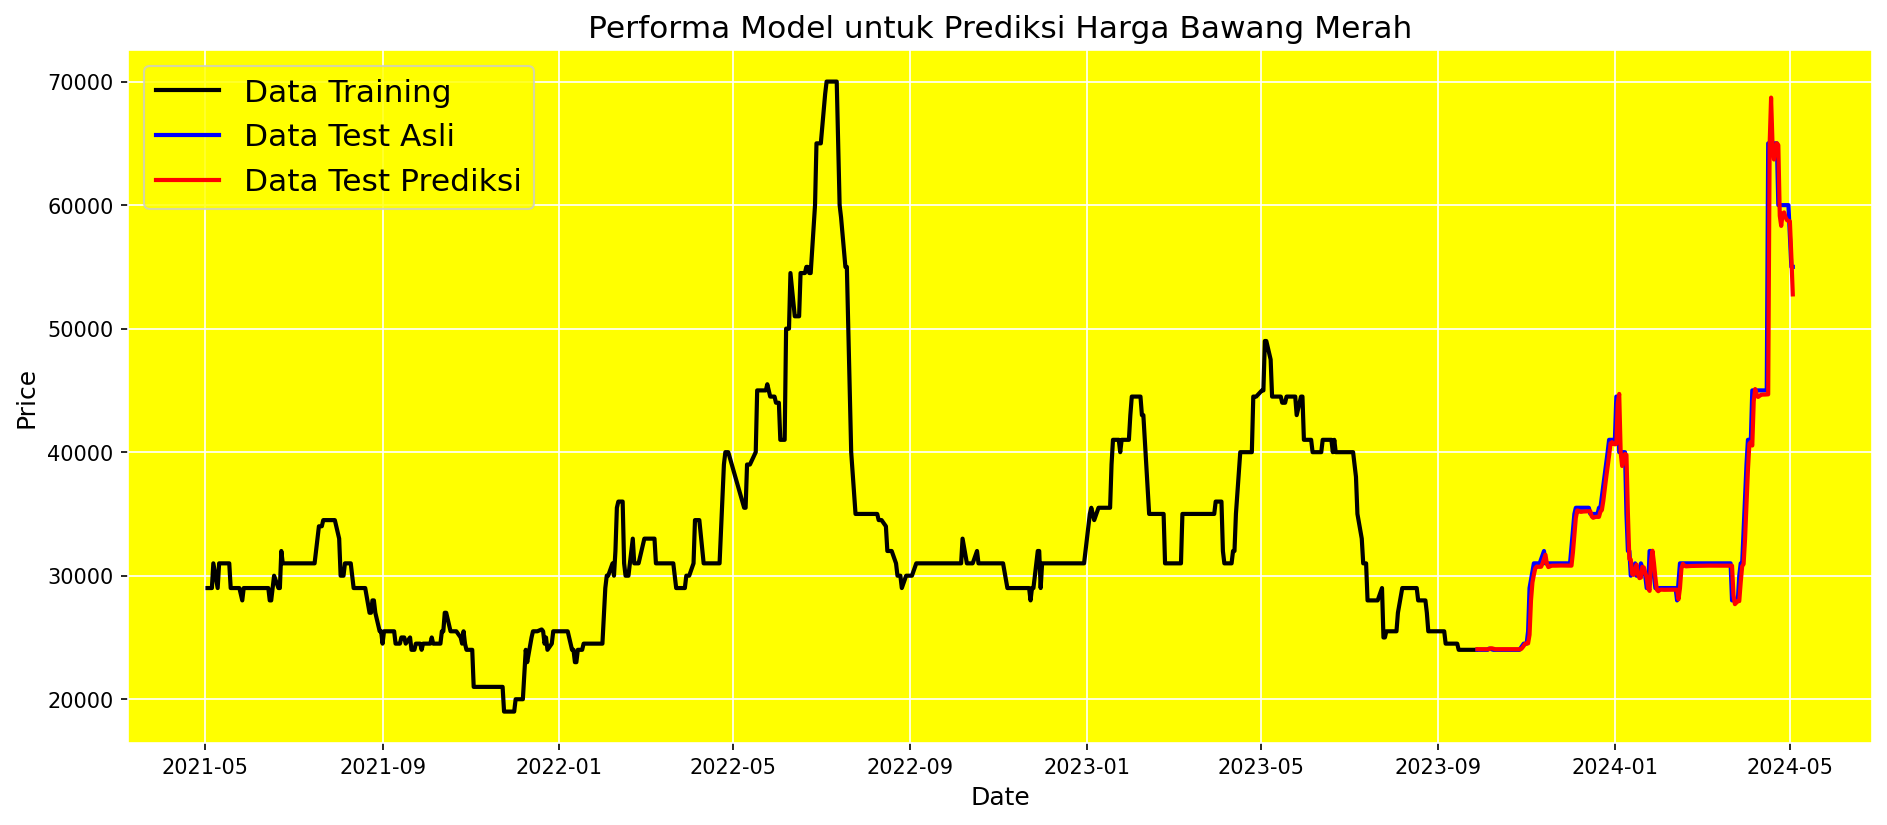

In [28]:
# Visualizing Results

# Mengembalikan nilai yang dinormalisasi ke data yang asli
y_test_true = np.round(scaler.inverse_transform(y_test))
y_test_pred = np.round(scaler.inverse_transform(y_pred))
real_train_data = scaler.inverse_transform(train_data)

# Menggambar Plot
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.date.iloc[:-test_size], real_train_data, color='black', lw=2)
plt.plot(df.date.iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df.date.iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Performa Model untuk Prediksi ' + y_axis_title_comodity[comodity_selected], fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Data Training', 'Data Test Asli', 'Data Test Prediksi'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

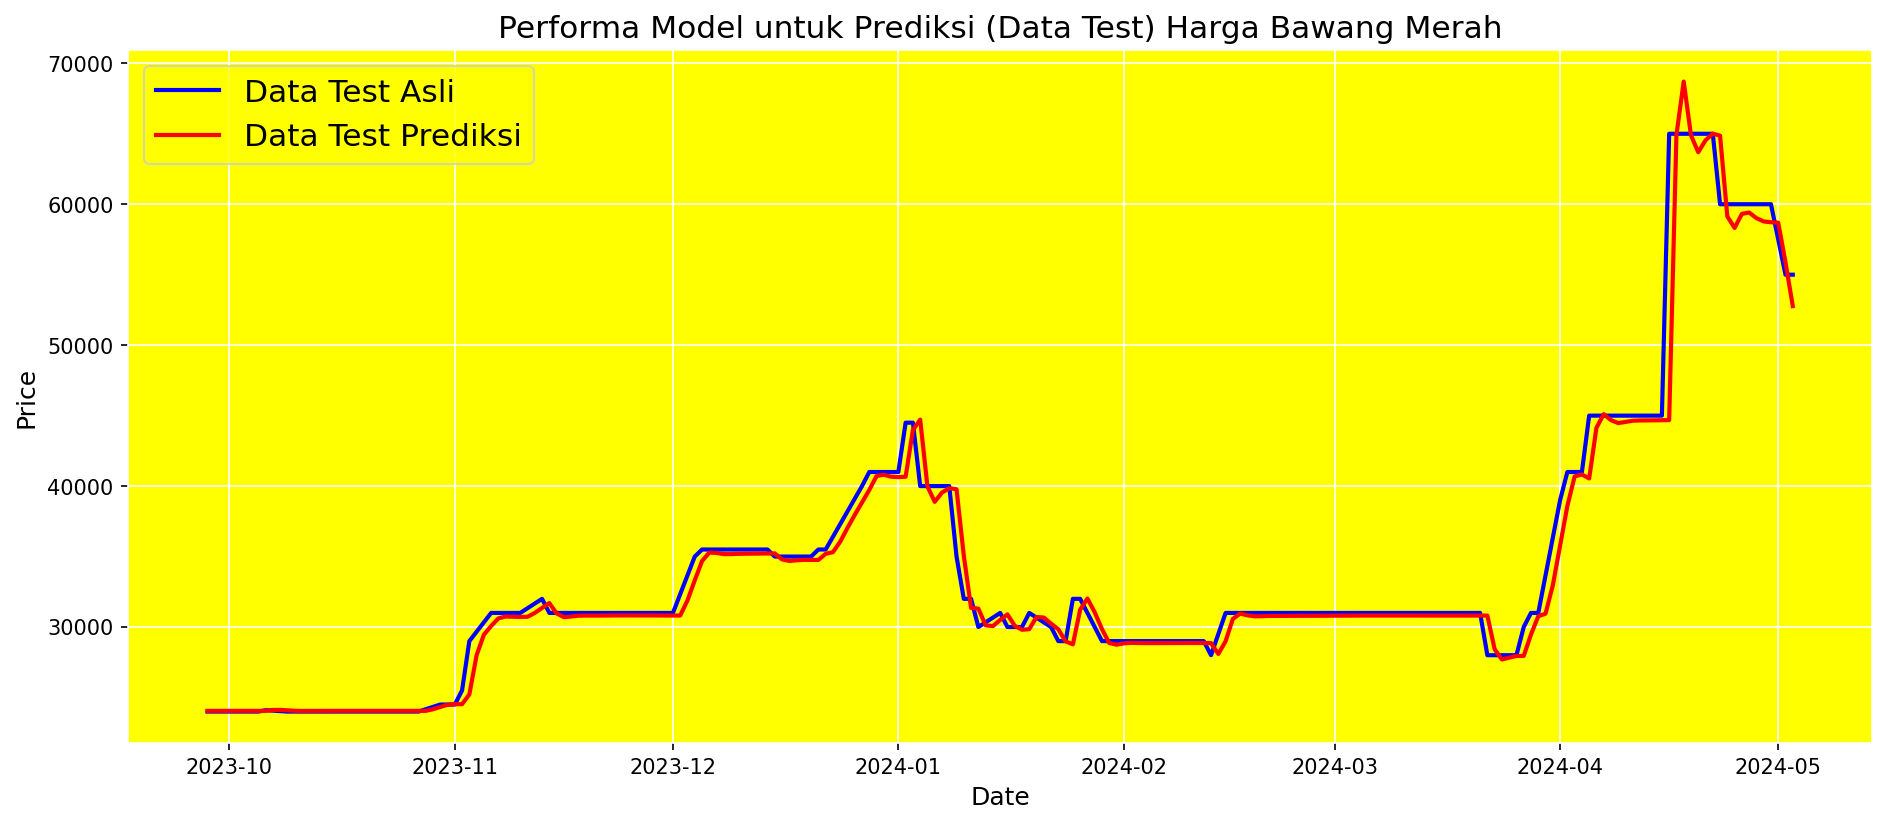

In [29]:
# Menggambar Plot Data Test Only
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.date.iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df.date.iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Performa Model untuk Prediksi (Data Test) ' + y_axis_title_comodity[comodity_selected], fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Data Test Asli', 'Data Test Prediksi'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [30]:
# Data Perbandingan dalam bentuk tabel
flatent_test_true = [item[0] for item in y_test_true]
flatent_test_pred = [item[0] for item in y_test_pred]

table_data = pd.DataFrame({
    'Date': df['date'].iloc[-test_size:],
    'Harga Asli': flatent_test_true,
    'Harga Prediksi': flatent_test_pred,
})

# Calculate the Percentage Error (often used in Mean Absolute Percentage Error or MAPE)
table_data['Persentase Error'] = ((table_data['Harga Asli'] / table_data['Harga Prediksi']) * 100)

table_data

,Date,Harga Asli,Harga Prediksi,Persentase Error
878,2023-09-28,24000.0,24051.0,99.787951
879,2023-09-29,24000.0,24050.0,99.792100
880,2023-09-30,24000.0,24050.0,99.792100
881,2023-10-01,24000.0,24050.0,99.792100
882,2023-10-02,24000.0,24049.0,99.796249
...,...,...,...,...
1092,2024-04-29,60000.0,58779.0,102.077272
1093,2024-04-30,60000.0,58722.0,102.176356
1094,2024-05-01,57500.0,58692.0,97.969059
1095,2024-05-02,55000.0,55876.0,98.432243


## Test Prediksi (Model Inference)

[[[0.351351]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.797297]
  [0.72973 ]
  [0.72973 ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[53145.984]
 [51805.832]
 [50127.473]]


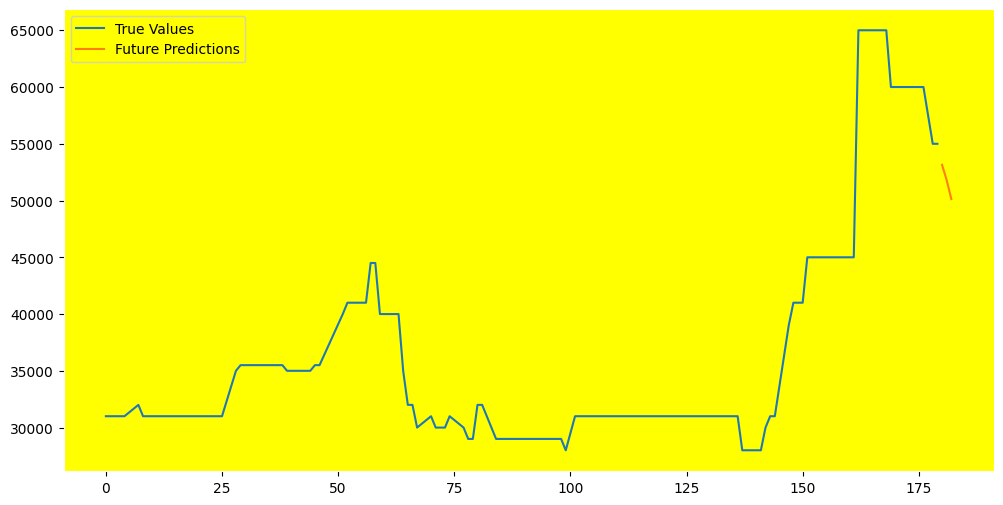

In [31]:
# Memprediksi X Hari Kedepan
target = df[comodity_list[comodity_selected]].tail(180).values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Membulatkan hingga 4 angka di belakang koma
scaled_target = np.round(scaled_target, 6)

# Predict future values
future_steps = 3  # Set the number of future steps you want to predict
future_data = scaled_target[-window_size:, :]

print(future_data.reshape((1, window_size, 1)))

future_predictions = []
for _ in range(future_steps):
    # Reshape the data to match the input shape of the model
    future_input = future_data.reshape((1, window_size, 1))

    # Make the prediction
    future_pred = model.predict(future_input)

    # Append the prediction to the results
    future_predictions.append(future_pred[0, 0])

    # Update the input data for the next prediction
    future_data = np.vstack((future_data[1:], future_pred))

# Inverse transform the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print(future_predictions)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target, label='True Values')
plt.plot(np.arange(len(target) , len(target) + future_steps), future_predictions, label='Future Predictions')
plt.legend()
plt.show()